#Experiment for Turbine 1

In this Notebook we're testing the importance of extensive feautre engineering, manuall. First on Dataset 1 and then we're going to apply all steps also to the other datasets


In [135]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import lightgbm as lgb
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# If running in google colab set this to True
run_in_colab = False

## 0.  Load data and create goal variable

In [136]:
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
if not run_in_colab:
    turbine1_train = pd.read_csv('../data/train_FD001.txt', delim_whitespace=True, header=None)
    turbine1_test = pd.read_csv('../data/test_FD001.txt', delim_whitespace=True, header=None)
    turbine2_train = pd.read_csv('../data/train_FD002.txt', delim_whitespace=True, header=None)
    turbine2_test = pd.read_csv('../data/test_FD002.txt', delim_whitespace=True, header=None)
    turbine3_train = pd.read_csv('../data/train_FD003.txt', delim_whitespace=True, header=None)
    turbine3_test = pd.read_csv('../data/test_FD003.txt', delim_whitespace=True, header=None)
    turbine4_train = pd.read_csv('../data/train_FD004.txt', delim_whitespace=True, header=None)
    turbine4_test = pd.read_csv('../data/test_FD004.txt', delim_whitespace=True, header=None)

    turbine1_rul_test = pd.read_csv('../data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
    turbine2_rul_test = pd.read_csv('../data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
    turbine3_rul_test = pd.read_csv('../data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
    turbine4_rul_test = pd.read_csv('../data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

In [138]:
if run_in_colab:
    data_dir = '/content/drive/My Drive/Colab Notebooks/' # Change directory according to your setup
    turbine1_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD001.txt', delim_whitespace=True, header=None)
    turbine1_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD001.txt', delim_whitespace=True, header=None)
    turbine2_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD002.txt', delim_whitespace=True, header=None)
    turbine2_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD002.txt', delim_whitespace=True, header=None)
    turbine3_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD003.txt', delim_whitespace=True, header=None)
    turbine3_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD003.txt', delim_whitespace=True, header=None)
    turbine4_train = pd.read_csv(data_dir + 'PSDA/Uebung2/data/train_FD004.txt', delim_whitespace=True, header=None)
    turbine4_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/test_FD004.txt', delim_whitespace=True, header=None)

    turbine1_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD001.txt',sep='\s+', header=None, names=["RUL"])
    turbine2_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD002.txt',sep='\s+', header=None, names=["RUL"])
    turbine3_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD003.txt',sep='\s+', header=None, names=["RUL"])
    turbine4_rul_test = pd.read_csv(data_dir + 'PSDA/Uebung2/data/RUL_FD004.txt',sep='\s+', header=None, names=["RUL"])

In [139]:
# Eingabedateien haben keine Spaltennamen, hier die Namen der Spalte wird definiert
# Es enthält 26 Spalten: Motornummer, Zeitschritt, Drei betriebsbereite Sensoreinstellungen und 21 Sensormessungen.

# Motornummer, Zeitschritt
index_columns_names =  ["UnitNumber","Cycle"]
# 3 betriebsbereite Sensoreinstellungen
operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
# 21 Sensormessungen
sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

turbine1_train.columns = input_file_column_names
turbine1_test.columns = input_file_column_names
turbine2_train.columns = input_file_column_names
turbine2_test.columns = input_file_column_names
turbine3_train.columns = input_file_column_names
turbine3_test.columns = input_file_column_names
turbine4_train.columns = input_file_column_names
turbine4_test.columns = input_file_column_names

In [140]:
# Dictionary to map old column names to new column names
rename_dict = {}
for col in turbine3_train.columns:
    if col == "UnitNumber":
        rename_dict[col] = "unitnr"
    elif col == "Cycle":
        rename_dict[col] = "cycle"
    elif "Operation Setting" in col:
        number = col.split()[-1]  # Extract the number part from the column name
        rename_dict[col] = f"os{number}"
    elif "Sensor Measure" in col:
        number = col.split("Measure")[-1]
        rename_dict[col] = f"sm{number}"

# List of your turbine DataFrame objects for training and testing
turbines_train = [turbine1_train, turbine2_train, turbine3_train, turbine4_train]
turbines_test = [turbine1_test, turbine2_test, turbine3_test, turbine4_test]

# Applying the renaming to each training and testing DataFrame
for df in turbines_train:
    df.rename(columns=rename_dict, inplace=True)

for df in turbines_test:
    df.rename(columns=rename_dict, inplace=True)

# Display the new DataFrame columns to verify changes
print(turbine3_train.columns)

Index(['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7',
       'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18',
       'sm19', 'sm20', 'sm21'],
      dtype='object')


In [141]:
# Sensor dictionairy from corresponding paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4711414
sensor_dict={}
dict_list=[ "(Total temperature at fan inlet) (◦R)",
"(Total temperature at LPC outlet) (◦R)",
"(Total temperature at HPC outlet) (◦R)",
"(Total temperature at LPT outlet) (◦R)",
"(Pressure at fan inlet) (psia)",
"(Total pressure in bypass-duct) (psia)",
"(Total pressure at HPC outlet) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(Static pressure at HPC outlet) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Demanded fan speed) (rpm)",
"(Demanded corrected fan speed) (rpm)",
"(HPT coolant bleed) (lbm/s)",
"(LPT coolant bleed) (lbm/s)" ]
i=1
for x in dict_list :
    sensor_dict['sm'+str(i)]=x
    i+=1
sensor_dict

{'sm1': '(Total temperature at fan inlet) (◦R)',
 'sm2': '(Total temperature at LPC outlet) (◦R)',
 'sm3': '(Total temperature at HPC outlet) (◦R)',
 'sm4': '(Total temperature at LPT outlet) (◦R)',
 'sm5': '(Pressure at fan inlet) (psia)',
 'sm6': '(Total pressure in bypass-duct) (psia)',
 'sm7': '(Total pressure at HPC outlet) (psia)',
 'sm8': '(Physical fan speed) (rpm)',
 'sm9': '(Physical core speed) (rpm)',
 'sm10': '(Engine pressure ratio(P50/P2)',
 'sm11': '(Static pressure at HPC outlet) (psia)',
 'sm12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sm13': '(Corrected fan speed) (rpm)',
 'sm14': '(Corrected core speed) (rpm)',
 'sm15': '(Bypass Ratio) ',
 'sm16': '(Burner fuel-air ratio)',
 'sm17': '(Bleed Enthalpy)',
 'sm18': '(Demanded fan speed) (rpm)',
 'sm19': '(Demanded corrected fan speed) (rpm)',
 'sm20': '(HPT coolant bleed) (lbm/s)',
 'sm21': '(LPT coolant bleed) (lbm/s)'}

In [142]:
turbine3_train.columns

Index(['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7',
       'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18',
       'sm19', 'sm20', 'sm21'],
      dtype='object')

In [143]:
# Add RUL column to the dataframes
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unitnr")
    max_cycle = grouped_by_unit["cycle"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unitnr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    result_frame.drop("max_cycle", axis=1, inplace=True)
    return result_frame

#Only for train data. Test data we dont have max_cycle
turbine1_train = add_remaining_useful_life(turbine1_train)
turbine2_train = add_remaining_useful_life(turbine2_train)
turbine3_train = add_remaining_useful_life(turbine3_train)
turbine4_train = add_remaining_useful_life(turbine4_train)

## 1. Define functions

We're defining some functions, that we're going to need several times

In [144]:
# Function to remove no/low variance
def remove_low_variation_columns(df, threshold=0.0001):
    """
    Remove columns from the DataFrame that have a standard deviation less than the specified threshold.

    Parameters:
    - df (pd.DataFrame): The DataFrame from which to remove low variation columns.
    - threshold (float): The threshold for the standard deviation below which columns will be removed.

    Returns:
    - pd.DataFrame: A DataFrame with the low variation columns removed.
    """
    # Calculate standard deviation for each column
    std_dev = df.std()

    # Filter out columns where the standard deviation is below the threshold
    filtered_df = df.loc[:, std_dev > threshold]

    # Print the remaining columns
    print("Remaining columns:", filtered_df.columns.tolist())

    return filtered_df

In [145]:
# Function to print 5 ids together
def print_time_series(dataframe, id=2):
    # Set up the colors for the plots
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']

    # Extract unique sensor measurement types from the dataframe
    sensor_measure_columns_names = [
        col for col in dataframe.columns
        if 'sm' in col or 'PC' in col  # Check for 'sm' and 'PC' in column names
    ]

    # Determine the number of sensor measurement types for subplot creation
    num_sensors = len(sensor_measure_columns_names)
    plt.figure(figsize=(15, 3 * num_sensors))

    # Determine the global maximum cycle number across the IDs of interest using the 'cycle' column
    global_max_cycle = 0
    for j in range(5):
        current_id = id + j
        current_df = dataframe[dataframe["unitnr"] == current_id]
        if not current_df.empty:
            max_cycle = current_df['cycle'].max()
            global_max_cycle = max(global_max_cycle, max_cycle)

    # Iterate over each sensor measurement type
    for i, col_name in enumerate(sensor_measure_columns_names):
        ax = plt.subplot(num_sensors, 1, i + 1)

        # Plot each ID from id to id + 4 on the same subplot
        for j in range(5):
            current_id = id + j
            dataframe_id = dataframe[dataframe["unitnr"] == current_id]

            # Correctly reverse the index so all data series align properly at the global maximum cycle
            if not dataframe_id.empty:
                # Data to plot
                cycles = dataframe_id['cycle'].values
                sensor_values = dataframe_id[col_name].values

                ax.plot(cycles, sensor_values, color=colors[j % len(colors)], label=f"ID {current_id}")

        ax.set_xlim(0, global_max_cycle)  # Set x-axis correctly
        ax.set_xlabel('Cycle Number')
        ax.set_ylabel(col_name)
        ax.legend()
        ax.title.set_text(f"Sensor: {col_name}")

    plt.tight_layout()
    plt.show()


## 2. Vizualizing and Experimenting

In [146]:
turbine1_train_og = turbine1_train
turbine1_test_og = turbine1_test

turbine1_train = remove_low_variation_columns(turbine1_train_og)
turbine1_test = remove_low_variation_columns(turbine1_test_og)

dropped_columns = ['os3', 'sm1', 'sm5', 'sm10', 'sm16', 'sm18', 'sm19']

Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21', 'RUL']
Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21']


###2.1 Looking at RUL

After Analysis of the RUL, we could think about remvoing high Outliers from the training dataset

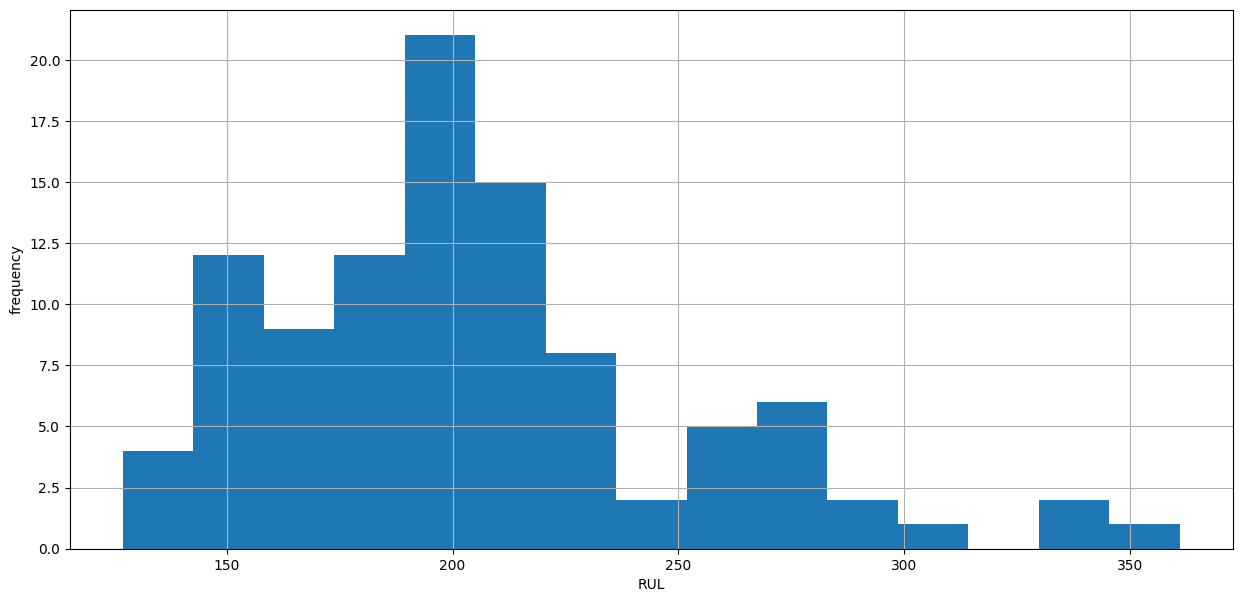

In [147]:
df_max_rul = turbine1_train[['unitnr', 'RUL']].groupby('unitnr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

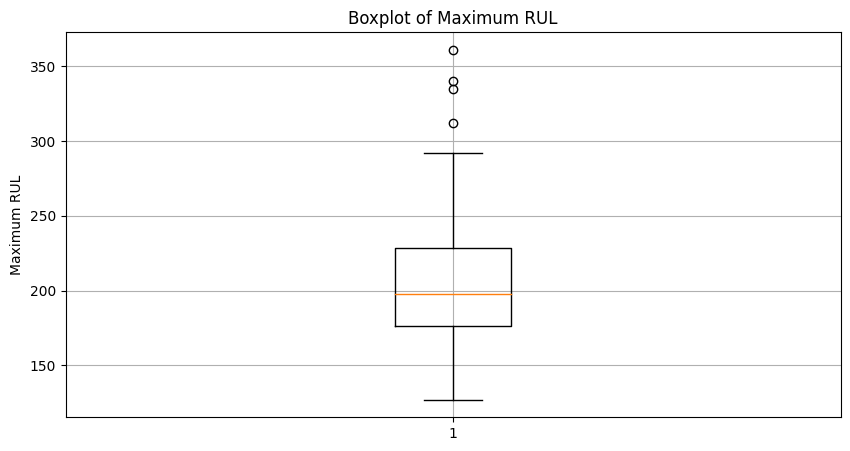

In [148]:
plt.figure(figsize=(10, 5))
plt.boxplot(df_max_rul['RUL'])
plt.title('Boxplot of Maximum RUL')
plt.ylabel('Maximum RUL')
plt.grid(True)
plt.show()

###2.2 Looking at specific features

We can see some specific trends, e.g. for sensor 6, that has special drops. We could create some specific variables to measure theses drops, but this is highly manually and different for each dataset

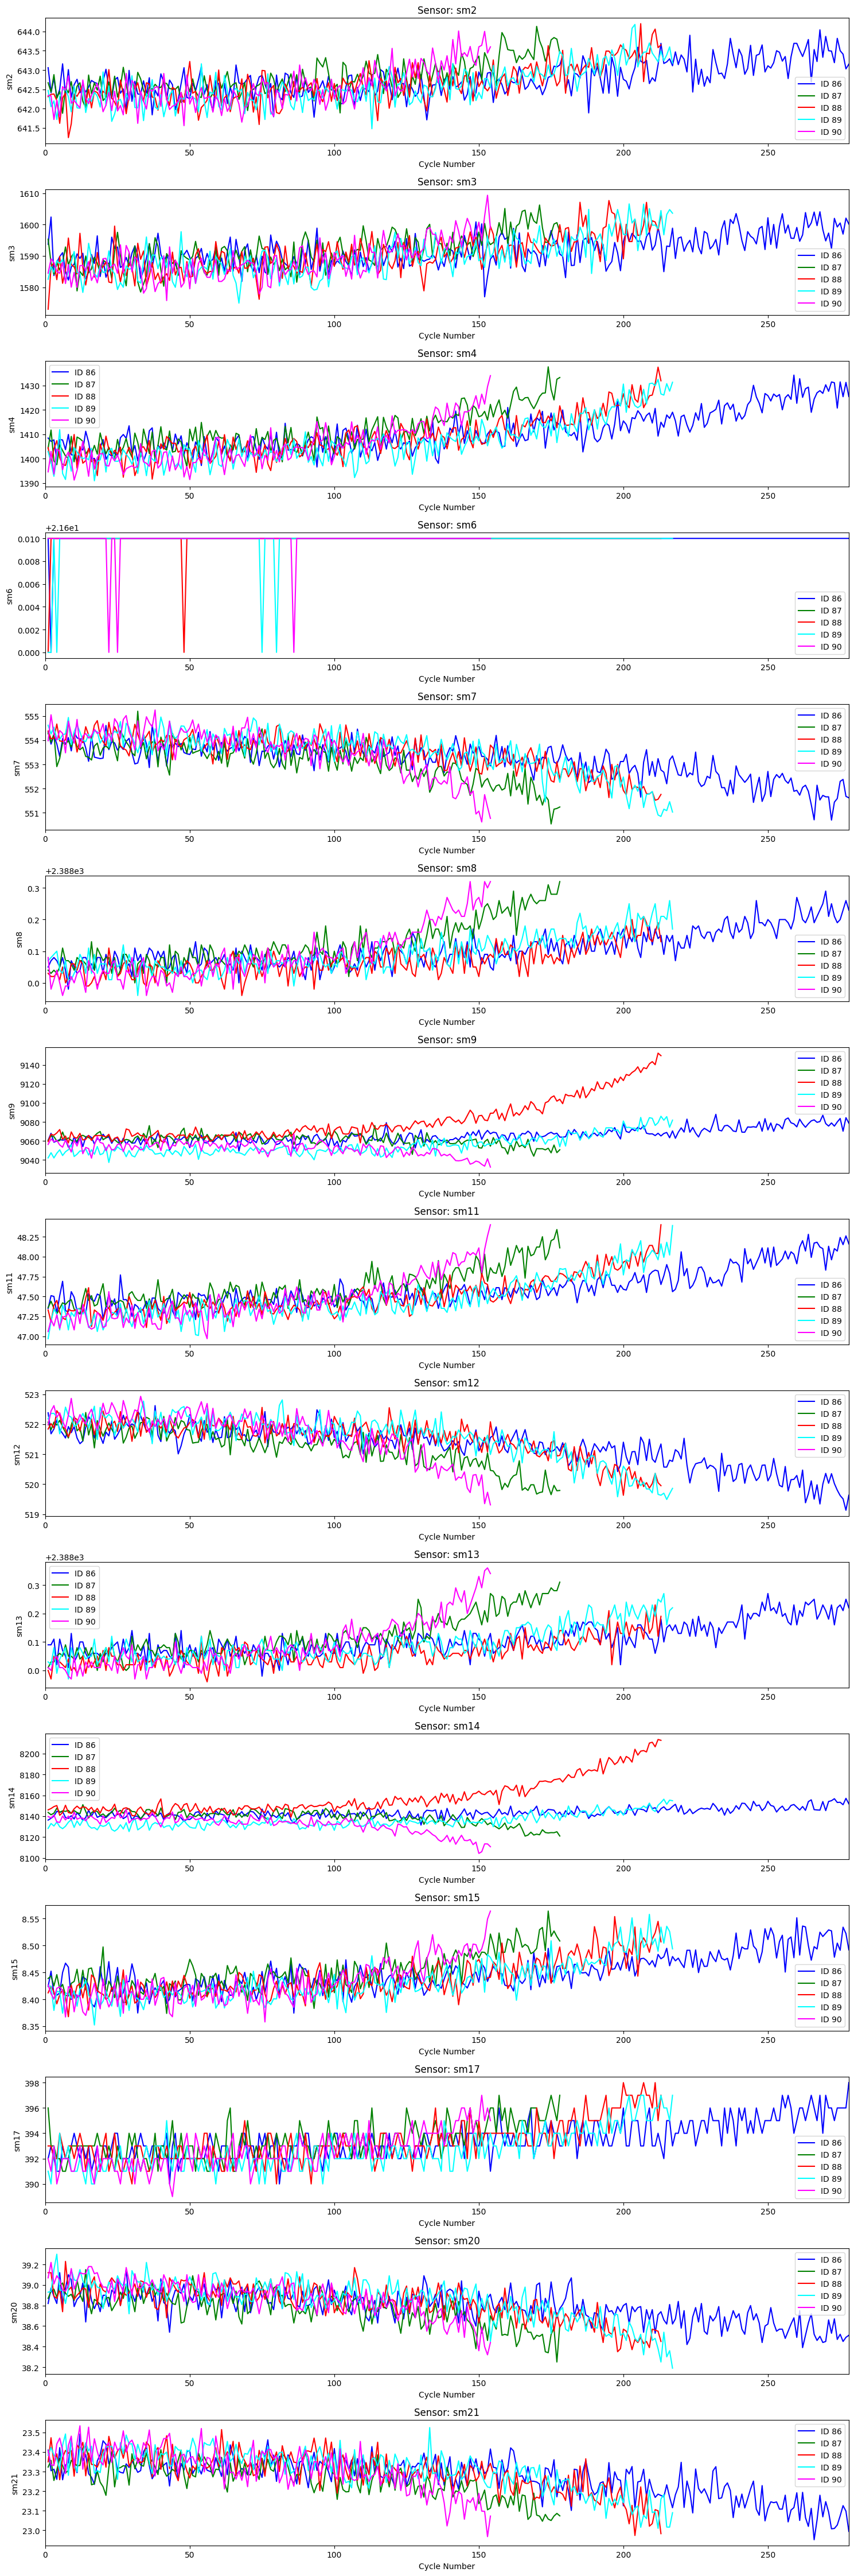

In [149]:
print_time_series(dataframe = turbine1_train, id=86)

###2.3 Correlation

Operational Settings don't seem to have any influence or correlate with any other feauter. Furthermore Sensor 9 and 14 are highly correlated, that's why we're going to remove sensor 14.

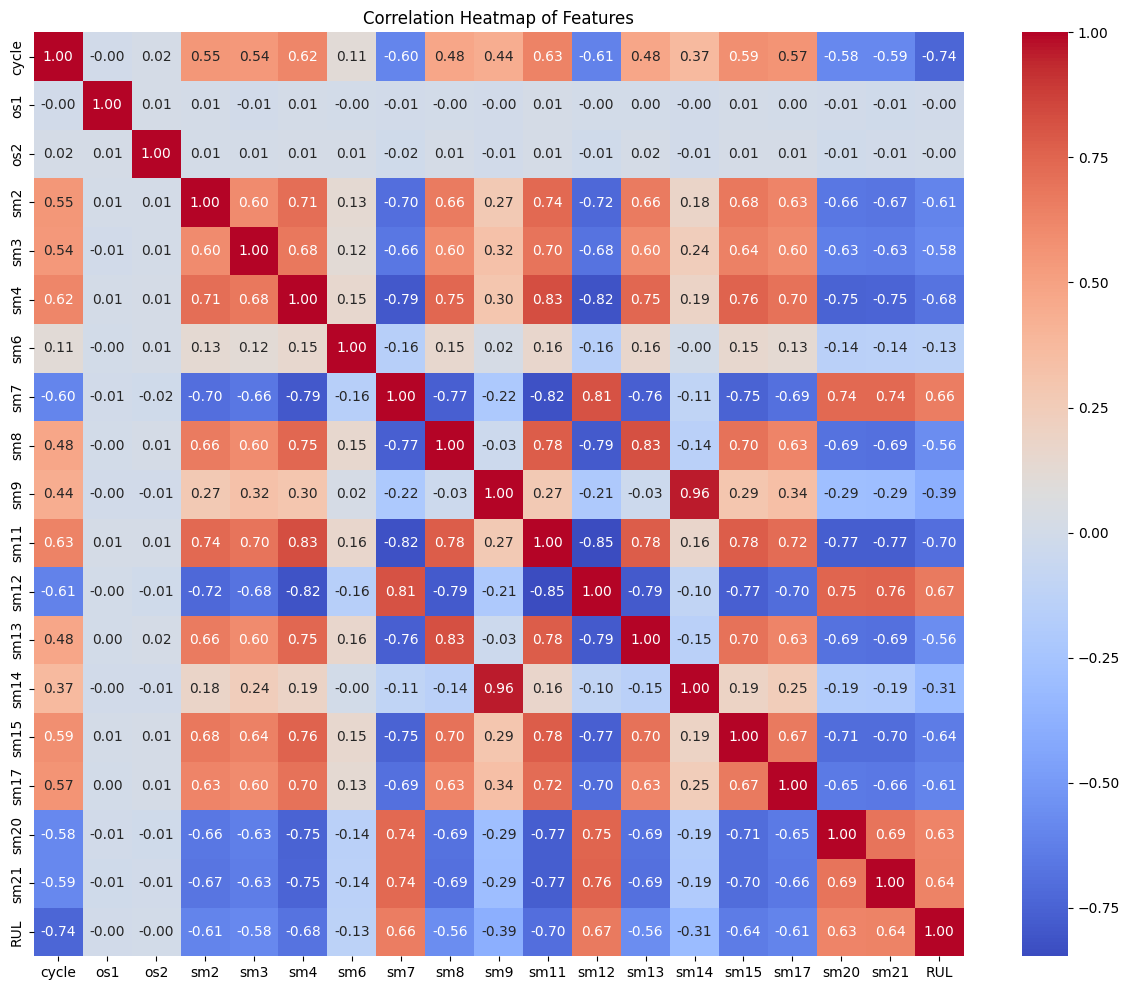

In [150]:
# Compute the correlation matrix for all columns except 'unitnr'
corr_matrix = turbine1_train.drop('unitnr', axis=1).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))  # Adjust the size of the figure as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

In [151]:
columns_to_drop = ["os1", "os2", "sm14"]
turbine1_train = turbine1_train.drop(columns=columns_to_drop)
turbine1_test = turbine1_test.drop(columns=columns_to_drop)

dropped_columns.extend(columns_to_drop)
print(dropped_columns)

['os3', 'sm1', 'sm5', 'sm10', 'sm16', 'sm18', 'sm19', 'os1', 'os2', 'sm14']


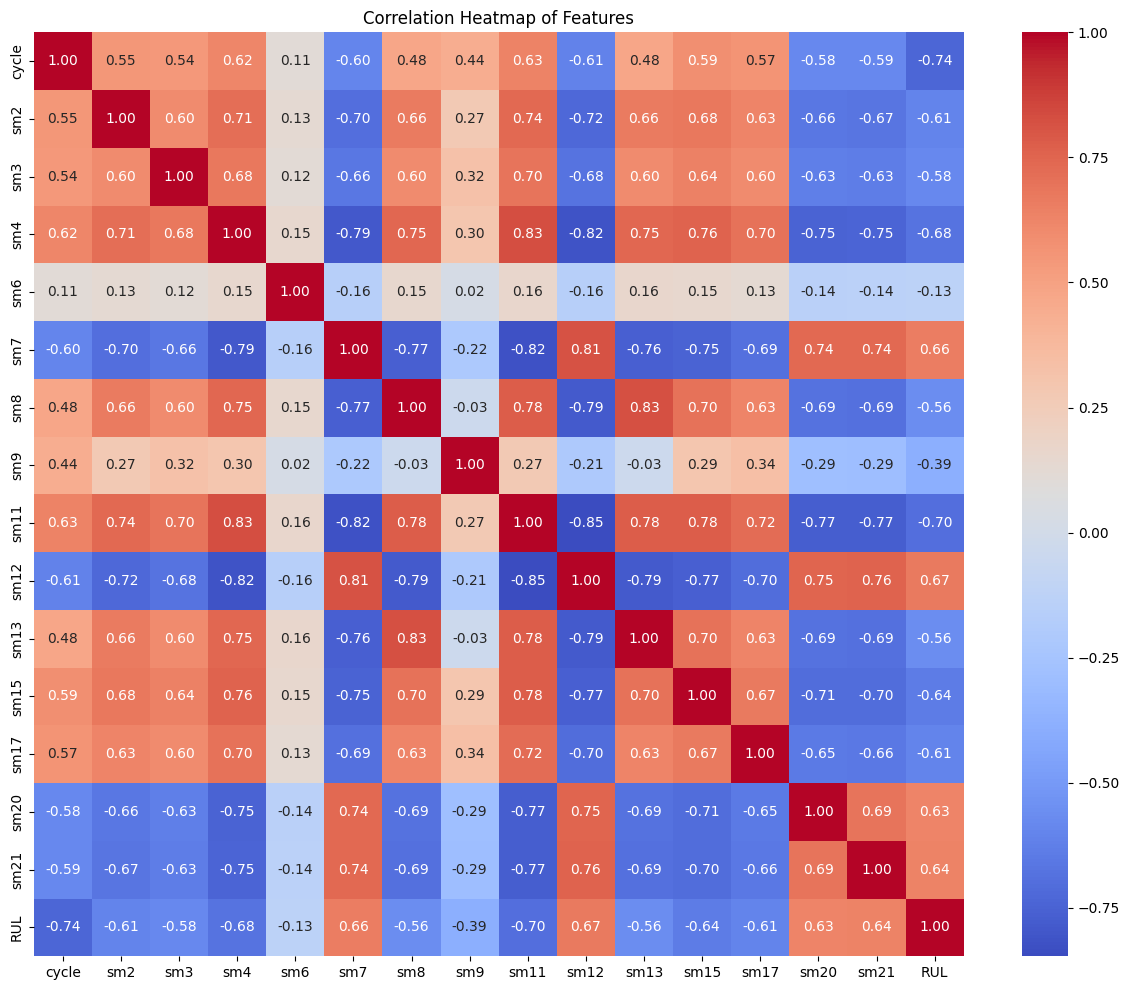

In [152]:
# Compute the correlation matrix for all columns except 'unitnr'
corr_matrix = turbine1_train.drop('unitnr', axis=1).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 12))  # Adjust the size of the figure as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features')
plt.show()

## Testing

He're we're trying some ways of feature engineering on dataset 1 to see what's working well and what not

We defined a custom function according to paper "Direct Remaining Useful Life Estimation Based on Random Forest Regression" (https://ieeexplore.ieee.org/abstract/document/9281004), which is punishing prediction of RULs that are too long harder, than the ones that are to short.

In [153]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

In [154]:
def train (dataset, RUL, **kwargs):
  # Modellinitialisierung
  model = lgb.LGBMRegressor(random_state=12, verbose = -1, **kwargs)
  # Model-Training
  model.fit(dataset, RUL)

  prediction = model.predict(dataset)

  #plt.figure(figsize=(12,5))
  #plt.plot((prediction[:2000]), label="Prediction")
  #plt.plot((RUL[:2000]), label="Reale RUL")
  #plt.legend()
  #plt.show()

  rms = sqrt(mean_squared_error(RUL.values.reshape(-1), prediction))
  score = custom_score(RUL, prediction)
  print("Der RMSE auf Trainingsdaten ist :", rms)
  print("Der Custom Score auf den Trainingsdaten ist: ", score)
  return model

In [155]:
def test(test_data, rul, model):
  prediction = model.predict(test_data)

  # Ensure 'rul' is a numpy array for calculations
  if isinstance(rul, pd.DataFrame) or isinstance(rul, pd.Series):
      rul = rul.values.reshape(-1)

  #plt.figure(figsize=(12,5))
  #plt.plot((prediction[:2000]), label="Prediction")
  #plt.plot((rul[:2000]), label="Reale RUL")
  #plt.legend()
  #plt.show()

  rms = sqrt(mean_squared_error(rul, prediction))
  score = custom_score(rul, prediction)
  print("Der RMSE auf Testdaten ist :", rms)
  print("Der Custom Score auf den Testdaten ist: ", score)
  print()

In [156]:
def get_last_and_scale(X, scaler):
    # Select the last cycle for each unit
    idx = X.groupby('unitnr')['cycle'].idxmax()
    X_test = X.loc[idx]

    # Drop the 'unitnr' column from the filtered test set
    X_test = X_test.drop(columns=["unitnr"])

    # Scale the data
    X_test_scaled = scaler.transform(X_test)
    return X_test_scaled

In [157]:
def plot_results(X_test, real_rul, model):
    predicted_rul = model.predict(X_test)

    real_rul = real_rul.values.reshape(-1)

    # Calculate limits for the diagonal line
    min_val = min(min(real_rul), min(predicted_rul))
    max_val = max(max(real_rul), max(predicted_rul))

    plt.figure(figsize=(12, 6))
    plt.scatter(predicted_rul, real_rul, label='Data points')  # swap the axes
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')  # Red diagonal line
    plt.legend()
    plt.title("Predicted RUL vs. real RUL")
    plt.xlabel("Predicted RUL")  # correctly labelling the x-axis
    plt.ylabel("Real RUL")  # correctly labelling the y-axis
    plt.show()

### Baseline Model

Without any Feature Engineering, just removing the constants, we get an RMSE of 16 on the test data

In [158]:
scaler = StandardScaler()

X = turbine1_train.drop(columns = ["RUL", "unitnr"])
X_scaled = scaler.fit_transform(X)
Y = turbine1_train["RUL"]
model = train(X_scaled, Y)

Der RMSE auf Trainingsdaten ist : 31.730523366619288
Der Custom Score auf den Trainingsdaten ist:  276.6337698888143


In [159]:
X_test_scaled = get_last_and_scale(turbine1_test, scaler)

test(X_test_scaled, turbine1_rul_test, model)

Der RMSE auf Testdaten ist : 26.448595501548457
Der Custom Score auf den Testdaten ist:  79.60845243346436



###Exponential Smoothing

Exponential Smoothing reduces the Error slightly on the Testdata, but highly on the train data

In [160]:
def calculate_exponential_smoothing(data, sensor_columns, span=5, unit_column='unitnr', cycle_column='cycle'):
    """
    Calculate exponential smoothing for sensor data within each unit.

    Parameters:
        data (DataFrame): The input DataFrame containing the data.
        sensor_columns (list): List of columns to apply the exponential smoothing.
        span (int): Specifies the span for the smoothing (similar to window size but provides smoothing factor).
        unit_column (str): Column name representing the unit identifier.
        cycle_column (str): Column name representing the cycle.

    Returns:
        DataFrame: A DataFrame with exponential smoothing computed, along with unit and cycle columns.
    """
    # Initialize an empty DataFrame to hold the smoothed data
    smoothed_data = pd.DataFrame()

    # Loop over each unit in the data
    for unit in data[unit_column].unique():
        # Filter data for the current unit
        unit_data = data[data[unit_column] == unit]

        # Apply exponential weighted function for smoothing
        es_unit_data = unit_data[sensor_columns].ewm(span=span, adjust=False).mean()

        # Include non-sensor columns that should remain unchanged
        non_sensor_data = unit_data[[unit_column, cycle_column]]

        # Concatenate the non-sensor data with the calculated smoothed data
        result_unit_data = pd.concat([non_sensor_data, es_unit_data], axis=1)

        # Append the processed data of the current unit to the overall DataFrame
        smoothed_data = pd.concat([smoothed_data, result_unit_data])

    return smoothed_data


In [161]:
columns_train = ['sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm11', 'sm12', 'sm13', 'sm15', 'sm17', 'sm20', 'sm21']

In [162]:
# Initialize the scaler
scaler = StandardScaler()

# Define spans for smoothing
spans = [5, 7, 10, 15, 20, 25, 30, 40]

for span in spans:
    print(f"Processing span: {span}")

    # Smooth training data
    X_train_smoothened = calculate_exponential_smoothing(turbine1_train, columns_train, span)
    X = X_train_smoothened.drop(columns=["unitnr"])
    X_scaled = scaler.fit_transform(X)
    Y = turbine1_train["RUL"]

    # Train the model
    model = train(X_scaled, Y)

    # Smooth test data
    X_test_smoothened = calculate_exponential_smoothing(turbine1_test, columns_train, span)
    X_test_scaled = get_last_and_scale(X_test_smoothened, scaler)  # ensure this scales using the already fitted scaler

    # Test the model
    test(X_test_scaled, turbine1_rul_test, model)

Processing span: 5
Der RMSE auf Trainingsdaten ist : 25.814138559242767
Der Custom Score auf den Trainingsdaten ist:  52.50633104764921
Der RMSE auf Testdaten ist : 27.32101747986228
Der Custom Score auf den Testdaten ist:  187.01571889874683

Processing span: 7
Der RMSE auf Trainingsdaten ist : 23.387310253817176
Der Custom Score auf den Trainingsdaten ist:  29.23896321116753
Der RMSE auf Testdaten ist : 25.865343050065015
Der Custom Score auf den Testdaten ist:  111.97314604773618

Processing span: 10
Der RMSE auf Trainingsdaten ist : 21.513183374350945
Der Custom Score auf den Trainingsdaten ist:  18.993848040311473
Der RMSE auf Testdaten ist : 27.51840304086401
Der Custom Score auf den Testdaten ist:  423.7655774776085

Processing span: 15
Der RMSE auf Trainingsdaten ist : 19.295302914690698
Der Custom Score auf den Trainingsdaten ist:  12.327871009585266
Der RMSE auf Testdaten ist : 26.70102118141678
Der Custom Score auf den Testdaten ist:  61.84455037640418

Processing span: 20
D

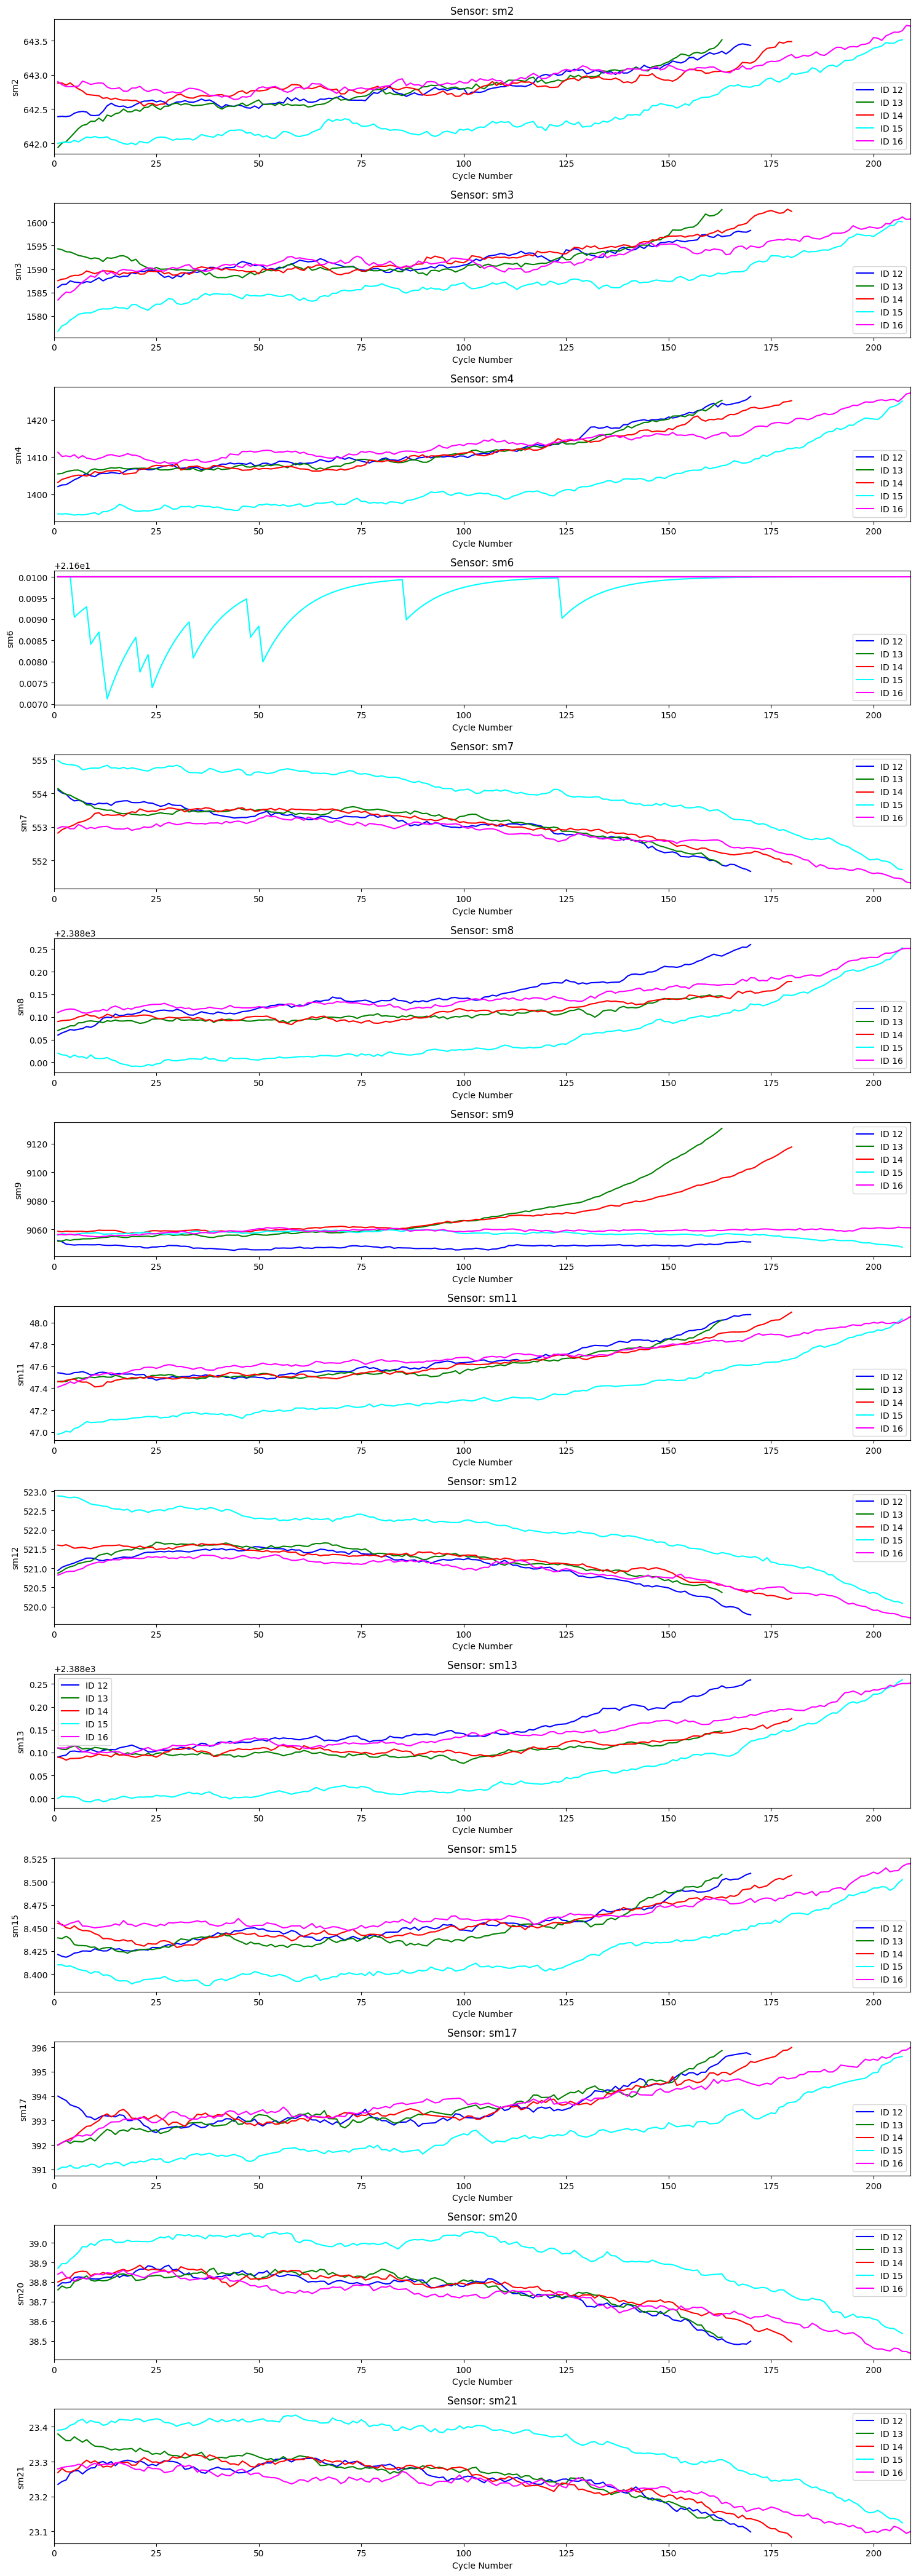

In [163]:
X_train_smoothened = calculate_exponential_smoothing(turbine1_train, columns_train, 20)
print_time_series(X_train_smoothened, id = 12)

### Capping RUL

Capping the RUL in Combination with the smoothened dataset seems really promising, so the Models don't learn to high RUL's and only learn the depriciation of the machine when it actually starts. It reduces the error a lot. Something around 120 and 130 seems to be the best value for capping the RUL. The best RMSE on the Testset is around 18 for right now


In [164]:
# Initialize the scaler
scaler = StandardScaler()

# Define spans for smoothing
caps = [100, 120, 130, 150]

for cap in caps:
    print(f"Capping span: {cap}")

    # Smooth training data
    X_train_smoothened = calculate_exponential_smoothing(turbine1_train, columns_train, 7)
    X = X_train_smoothened.drop(columns=["unitnr"])
    X_scaled = scaler.fit_transform(X)
    Y = turbine1_train["RUL"]
    Y = Y.apply(lambda x: min(x, cap))

    # Train the model
    model = train(X_scaled, Y)

    # Smooth test data
    X_test_smoothened = calculate_exponential_smoothing(turbine1_test, columns_train, 7)
    X_test_scaled = get_last_and_scale(X_test_smoothened, scaler)  # ensure this scales using the already fitted scaler

    # Test the model
    test(X_test_scaled, turbine1_rul_test, model)

Capping span: 100
Der RMSE auf Trainingsdaten ist : 6.076496626530563
Der Custom Score auf den Trainingsdaten ist:  0.6152979046826109
Der RMSE auf Testdaten ist : 20.391124404065796
Der Custom Score auf den Testdaten ist:  5.8720351164017925

Capping span: 120
Der RMSE auf Trainingsdaten ist : 8.842640394069246
Der Custom Score auf den Trainingsdaten ist:  1.247908400172668
Der RMSE auf Testdaten ist : 18.186270993465488
Der Custom Score auf den Testdaten ist:  5.229811412840209

Capping span: 130
Der RMSE auf Trainingsdaten ist : 10.256796863401284
Der Custom Score auf den Trainingsdaten ist:  1.6905406448731977
Der RMSE auf Testdaten ist : 18.141330479806857
Der Custom Score auf den Testdaten ist:  5.791223243535629

Capping span: 150
Der RMSE auf Trainingsdaten ist : 12.924050729097738
Der Custom Score auf den Trainingsdaten ist:  2.878430028457476
Der RMSE auf Testdaten ist : 20.803923781799586
Der Custom Score auf den Testdaten ist:  9.554549821282984



### Moving Average

Exponential Smoothing seems to work better, then Moving Average, as the results here are worse, then above (capped, and smoothened)

In [165]:
def calculate_moving_averages(data, sensor_columns, window_size=5, unit_column='unitnr', cycle_column='cycle'):
    """
    Calculate moving averages for sensor data within each unit and ensure the output matches the input length.

    Parameters:
        data (DataFrame): The input DataFrame containing the data.
        sensor_columns (list): List of columns to apply the moving average.
        window_size (int): The number of cycles over which to calculate the moving average.
        unit_column (str): Column name representing the unit identifier.
        cycle_column (str): Column name representing the cycle.

    Returns:
        DataFrame: A DataFrame with moving averages computed, along with unit and cycle columns.
    """
    # Initialize an empty DataFrame to hold the moving averages
    moving_avg_data = pd.DataFrame()

    # Loop over each unit in the data
    for unit in data[unit_column].unique():
        # Filter data for the current unit
        unit_data = data[data[unit_column] == unit]

        # Apply rolling window moving average
        ma_unit_data = unit_data[sensor_columns].rolling(window=window_size, min_periods=1).mean()

        # Since rolling operation may create NaN, use forward fill to handle initial NaN values
        ma_unit_data.fillna(method='ffill', inplace=True)
        ma_unit_data.fillna(method='bfill', inplace=True)  # Ensure all NaNs are filled

        # Include non-sensor columns that should remain unchanged
        non_sensor_data = unit_data[[unit_column, cycle_column]]

        # Concatenate the non-sensor data with the calculated moving averages
        result_unit_data = pd.concat([non_sensor_data, ma_unit_data], axis=1)

        # Append the processed data of the current unit to the overall DataFrame
        moving_avg_data = pd.concat([moving_avg_data, result_unit_data])

    return moving_avg_data

In [166]:
# Initialize the scaler
scaler = StandardScaler()

# Define spans for smoothing
spans = [5, 7, 10, 15, 20, 25, 30, 40]

for span in spans:
    print(f"Processing span: {span}")

    # Smooth training data
    X_train_smoothened = calculate_moving_averages(turbine1_train, columns_train, span)
    X = X_train_smoothened.drop(columns=["unitnr"])
    X_scaled = scaler.fit_transform(X)
    Y = turbine1_train["RUL"]
    Y = Y.apply(lambda x: min(x, 130))

    # Train the model
    model = train(X_scaled, Y)

    # Smooth test data
    X_test_smoothened = calculate_moving_averages(turbine1_test, columns_train, span)
    X_test_scaled = get_last_and_scale(X_test_smoothened, scaler)  # ensure this scales using the already fitted scaler

    # Test the model
    test(X_test_scaled, turbine1_rul_test, model)

Processing span: 5
Der RMSE auf Trainingsdaten ist : 12.042444402149897
Der Custom Score auf den Trainingsdaten ist:  2.5658369230163216
Der RMSE auf Testdaten ist : 21.300072659071844
Der Custom Score auf den Testdaten ist:  9.933233096447417

Processing span: 7
Der RMSE auf Trainingsdaten ist : 11.339085448965841
Der Custom Score auf den Trainingsdaten ist:  2.163967124347579
Der RMSE auf Testdaten ist : 21.34755938639767
Der Custom Score auf den Testdaten ist:  12.439304604884022

Processing span: 10
Der RMSE auf Trainingsdaten ist : 10.41504385547526
Der Custom Score auf den Trainingsdaten ist:  1.761283687576066
Der RMSE auf Testdaten ist : 21.648544782545283
Der Custom Score auf den Testdaten ist:  12.051760690467558

Processing span: 15
Der RMSE auf Trainingsdaten ist : 9.5177739965007
Der Custom Score auf den Trainingsdaten ist:  1.4294872433914843
Der RMSE auf Testdaten ist : 23.379038709557893
Der Custom Score auf den Testdaten ist:  32.331578670192656

Processing span: 20
De

### Removing RUL Outliers from the Trainset

The relults don't improve removing high RUL Outliers

In [167]:
def remove_outlier_machines_and_print(df, unit_column='unitnr', cycle_column='cycle'):
    import pandas as pd

    # Calculate max cycles per machine
    max_cycles = df.groupby(unit_column)[cycle_column].max().reset_index()
    max_cycles.columns = [unit_column, 'max_cycle']

    # Calculate IQR and determine outliers
    Q1 = max_cycles['max_cycle'].quantile(0.25)
    Q3 = max_cycles['max_cycle'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outlier units
    outlier_units = max_cycles[(max_cycles['max_cycle'] < lower_bound) | (max_cycles['max_cycle'] > upper_bound)][unit_column]

    # Print the cycles of the removed machines
    if not outlier_units.empty:
        for unit in outlier_units:
            removed_cycles = df[df[unit_column] == unit][cycle_column].tolist()
            print(f"Removed cycles for machine {unit}: {removed_cycles}")
    else:
        print("No outlier machines found.")

    # Filter out outliers
    filtered_df = df[~df[unit_column].isin(outlier_units)]
    return filtered_df

# Usage
cleaned_df = remove_outlier_machines_and_print(turbine1_train)


Removed cycles for machine 67: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2

In [168]:
X_train_smoothened = calculate_exponential_smoothing(cleaned_df, columns_train, 7)
X = X_train_smoothened.drop(columns=["unitnr"])
X_scaled = scaler.fit_transform(X)
Y = cleaned_df["RUL"]
Y = Y.apply(lambda x: min(x, 130))

# Train the model
model = train(X_scaled, Y)

# Smooth test data
X_test_smoothened = calculate_exponential_smoothing(turbine1_test, columns_train, 7)
X_test_scaled = get_last_and_scale(X_test_smoothened, scaler)  # ensure this scales using the already fitted scaler

# Test the model
test(X_test_scaled, turbine1_rul_test, model)

Der RMSE auf Trainingsdaten ist : 9.202440517627121
Der Custom Score auf den Trainingsdaten ist:  1.3473255493192884
Der RMSE auf Testdaten ist : 19.217704199611468
Der Custom Score auf den Testdaten ist:  5.983102276931876



### Creation of several new features over different rolling windows

Here we're trying to create a lot of new features especially variance, average and slope over several timeperiods.

This is a revised and specialized version of the sliding window method, using different timespans, different created features and implementing faster pandas-functions instead of tsfresh. Especially rolling-method from panda is faster than tsfresh.

In [169]:
def enhance_turbofan_features(df, sensor_columns, short_span=7, long_days=[15, 30, 60, 90], unit_column='unitnr', cycle_column='cycle'):
    """
    Enhance features by calculating rolling statistics and exponential smoothing for specified sensor columns.
    Also retains specified non-sensor columns unmodified.

    Parameters:
        df (DataFrame): The input DataFrame containing the data.
        sensor_columns (list): List of sensor column names to apply the calculations.
        short_span (int): Span for short-term exponential smoothing.
        long_days (list of int): List of days to calculate long-term rolling statistics.
        unit_column (str): Column name for unit identification.
        cycle_column (str): Column name for cycle count.

    Returns:
        DataFrame: A DataFrame with enhanced features, including unmodified unit and cycle columns.
    """
    # Unique identifiers for each machine
    unit_numbers = df[unit_column].unique()

    # Prepare an empty dataframe to hold enhanced features
    enhanced_df = pd.DataFrame()

    for unit in unit_numbers:
        # Filter data for the current machine
        df_unit = df[df[unit_column] == unit].copy()

        # Apply calculations only for specified sensor columns
        for col in sensor_columns:
            # Calculate exponential averages using span
            df_unit[f'{col}_exp_smooth'] = df_unit[col].ewm(span=short_span, adjust=False).mean()
            df_unit[f'{col}_rolling_max'] = df_unit[col].expanding().max()
            df_unit[f'{col}_rolling_min'] = df_unit[col].expanding().min()
            df_unit[f'{col}_start_diff'] = df_unit[col] - df_unit[col].iloc[0]

            # Long-term averages, variance, and slope calculations
            for days in long_days:
                df_unit[f'{col}_{days}d_avg'] = df_unit[col].rolling(window=days, min_periods=1).mean()
                df_unit[f'{col}_{days}d_var'] = df_unit[col].rolling(window=days, min_periods=1).var()

                # Calculate slope using a rolling window applying linear regression
                if len(df_unit) >= days:
                    slopes = df_unit[col].rolling(window=days).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True)
                    df_unit[f'{col}_{days}d_slope'] = slopes
                else:
                    df_unit[f'{col}_{days}d_slope'] = np.nan

        # Include non-sensor columns that should remain unchanged
        non_sensor_data = df_unit[[unit_column, cycle_column]]

        # Concatenate the non-sensor data with the calculated smoothed data
        result_unit_data = pd.concat([non_sensor_data, df_unit.drop([unit_column, cycle_column], axis=1)], axis=1)

        # Append the results for this unit to the enhanced dataframe
        enhanced_df = pd.concat([enhanced_df, result_unit_data], ignore_index=True)

    return enhanced_df


In [170]:
import warnings
from pandas.errors import PerformanceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=PerformanceWarning)


# Initialize the scaler
scaler = StandardScaler()

X_train_enhanced = enhance_turbofan_features(turbine1_train, columns_train)
X = X_train_enhanced.drop(columns=["unitnr", "RUL"])
X_scaled = scaler.fit_transform(X)
Y = turbine1_train["RUL"]

# Smooth test data
X_test_enhanced = enhance_turbofan_features(turbine1_test, columns_train)
X_test_scaled = get_last_and_scale(X_test_enhanced, scaler)  # ensure this scales using the already fitted scaler


In [171]:
#Capping at 120 works best for set 1
Y = Y.apply(lambda x: min(x, 120))

# Train the model
model = train(X_scaled, Y)

# Test the model
test(X_test_scaled, turbine1_rul_test, model)

Der RMSE auf Trainingsdaten ist : 2.067170084796978
Der Custom Score auf den Trainingsdaten ist:  0.14794418212497867
Der RMSE auf Testdaten ist : 12.848283204046135
Der Custom Score auf den Testdaten ist:  2.2677307756597824



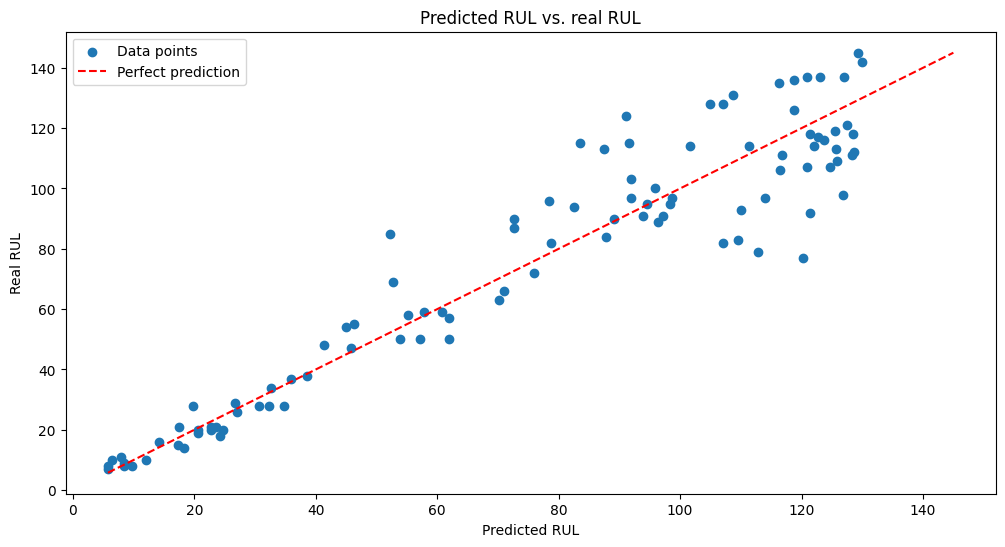

In [104]:
plot_results(X_test_scaled, turbine1_rul_test, model)

#### Trying to avoid overfitting

As we can see we get really good resulst with this type of feature engineering, real close to actual literature. To avoid overfitting slightly, we are going to try to remove some unnecessary feature and use some specific hyperparameters. Playing around with some parameters manually, we couldn't see any significant effect and any significant improvement. Actually it only got worse

Due to time constrains and computational power constrains we weren't able to perform a whole grid-search and further variable selection. Anyways as trees are known to perform good with a lot of features, and the result is really good, we're going to apply the same technique on the other datasets lastly

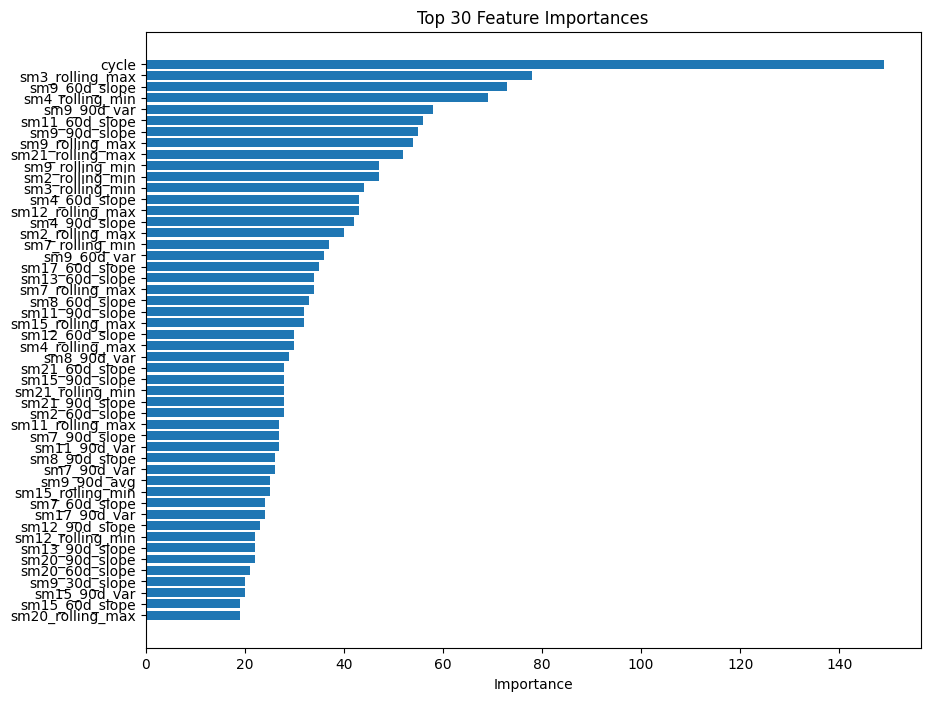

In [105]:
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Sort and select the top 30 most important features
top_50_features = feature_importance_df.head(50)

# Create a horizontal bar chart of the top 30 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

In [106]:
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

top_50_features = top_50_features['Feature'].tolist()

# Subset the scaled training and test DataFrames to include only the top 50 features
X_scaled_top50 = X_scaled_df[top_50_features]
X_test_scaled_top50 = X_test_scaled_df[top_50_features]

In [107]:
# Train the model
model = train(X_scaled_top50, Y, feature_fraction = 0.8, subsample = 0.8, reg_lambda = 2, reg_alpha = 2)

# Test the model
test(X_test_scaled_top50, turbine1_rul_test, model)

Der RMSE auf Trainingsdaten ist : 2.6139704055299213
Der Custom Score auf den Trainingsdaten ist:  0.19835432449667986
Der RMSE auf Testdaten ist : 13.790765999887647
Der Custom Score auf den Testdaten ist:  3.051170907697015



# Evaluate on other datsets

**Important steps**

*   Remove constant values
*   Create a Baseline Model
*   Apply RUL-Capping and enhanced model function



## Turbine 2

Bad resulst, further analysis needed. Propably due to different operational modes and overfitting.
Furthermore in the plot we can see that we need a different boarder to cap the RUL.

In [108]:
turbine2_train = remove_low_variation_columns(turbine2_train)
turbine2_test = remove_low_variation_columns(turbine2_test)

Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21', 'RUL']
Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']


In [109]:
columns_train = turbine2_train.filter(regex='sm|os').columns.tolist()

# Print the list of column names
print(columns_train)

['os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']


In [110]:
# Initialize the scaler
scaler = StandardScaler()

# Prepare training data
X_train = turbine2_train.drop(columns=["RUL", "unitnr"])  # Assuming 'RUL' and 'unitnr' need to be dropped
X_train_scaled = scaler.fit_transform(X_train)
Y_train = turbine2_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 130))

# Train the model
model = train(X_train_scaled, Y_train)

# Prepare and scale test data
X_test_scaled = get_last_and_scale(turbine2_test, scaler)

# Test the model
test(X_test_scaled, turbine2_rul_test, model)

Der RMSE auf Trainingsdaten ist : 16.732435817855013
Der Custom Score auf den Trainingsdaten ist:  6.205726778845176
Der RMSE auf Testdaten ist : 27.14151519986045
Der Custom Score auf den Testdaten ist:  32.58655896992946



In [111]:
# Enhance features for the training data
X_train_enhanced = enhance_turbofan_features(turbine2_train, columns_train)  # Assuming 'columns_train' is defined
X_train = X_train_enhanced.drop(columns=["unitnr", "RUL"])
X_train_scaled = scaler.fit_transform(X_train)
Y_train = turbine2_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 130))  # Apply capping if needed

# Enhance features for the test data
X_test_enhanced = enhance_turbofan_features(turbine2_test, columns_train)
X_test_scaled = get_last_and_scale(X_test_enhanced, scaler)  # Use the same scaler as before

# Train the model with enhanced features
model = train(X_train_scaled, Y_train)

# Test the model with enhanced features
test(X_test_scaled, turbine2_rul_test, model)

Der RMSE auf Trainingsdaten ist : 5.011471313718242
Der Custom Score auf den Trainingsdaten ist:  0.46788343244820485
Der RMSE auf Testdaten ist : 29.753514727402198
Der Custom Score auf den Testdaten ist:  56.795300250657895



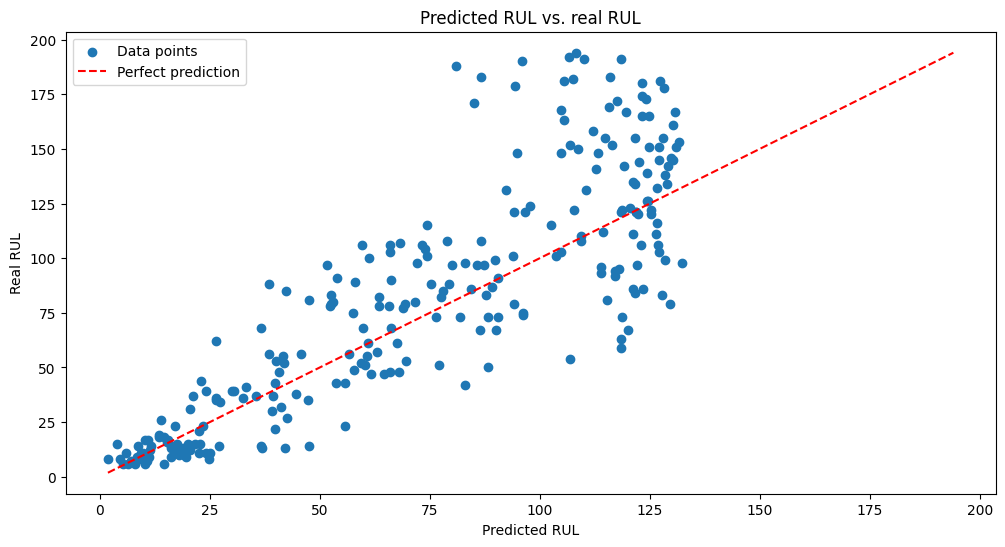

In [112]:
plot_results(X_test_scaled, turbine2_rul_test, model)

In [113]:
#Try higher RUL to see whether the results improve

Y_train = turbine2_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 170))

# Train the model with enhanced features
model = train(X_train_scaled, Y_train)

# Test the model with enhanced features
test(X_test_scaled, turbine2_rul_test, model)

Der RMSE auf Trainingsdaten ist : 6.780945929978307
Der Custom Score auf den Trainingsdaten ist:  0.7674187264087383
Der RMSE auf Testdaten ist : 29.247883748025767
Der Custom Score auf den Testdaten ist:  65.5583865503793



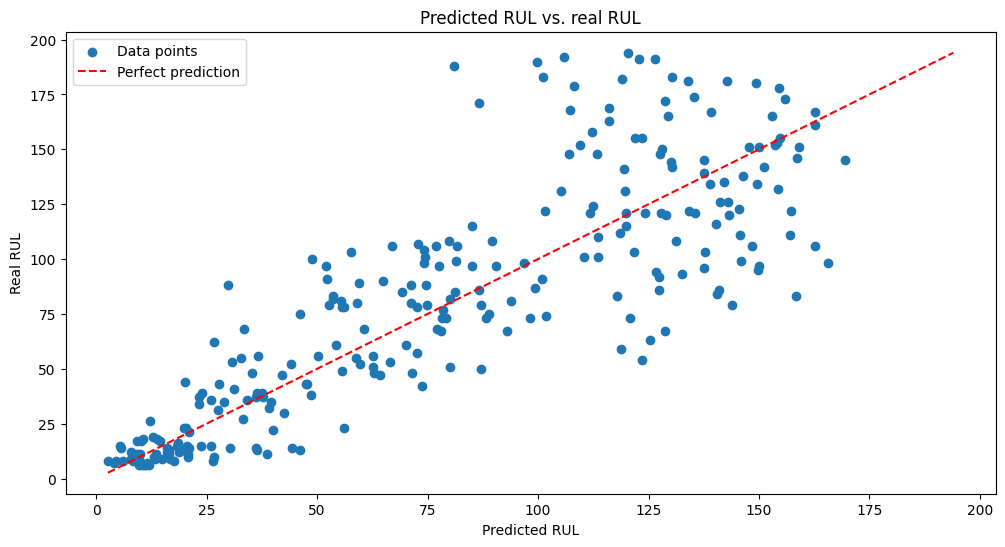

In [114]:
plot_results(X_test_scaled, turbine2_rul_test, model)

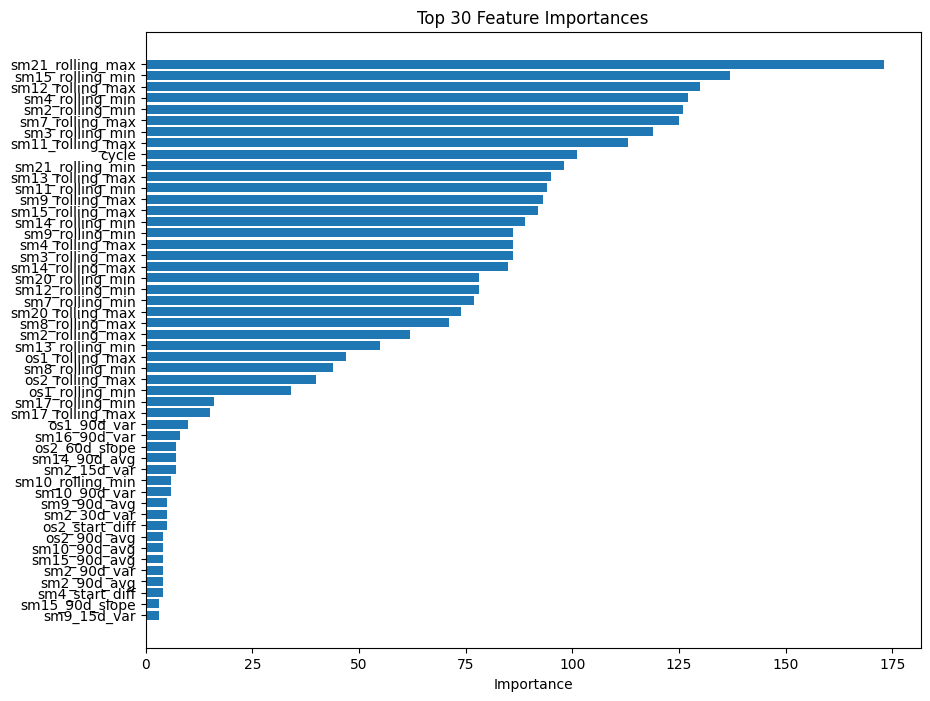

In [115]:
importances = model.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Sort and select the top 30 most important features
top_50_features = feature_importance_df.head(50)

# Create a horizontal bar chart of the top 30 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

## Turbine 3

real good results :-), but need to ajust the CAP for RUL slightly

In [116]:
turbine3_train = remove_low_variation_columns(turbine3_train)
turbine3_test = remove_low_variation_columns(turbine3_test)

Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21', 'RUL']
Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21']


In [117]:
columns_train = turbine3_train.filter(regex='sm|os').columns.tolist()

# Print the list of column names
print(columns_train)

['os1', 'os2', 'sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm17', 'sm20', 'sm21']


In [118]:
scaler = StandardScaler()

X = turbine3_train.drop(columns = ["RUL", "unitnr"])
X_scaled = scaler.fit_transform(X)
Y = turbine3_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 130))
model = train(X_scaled, Y)

X_test_scaled = get_last_and_scale(turbine3_test, scaler)

test(X_test_scaled, turbine3_rul_test, model)

Der RMSE auf Trainingsdaten ist : 42.35729717453407
Der Custom Score auf den Trainingsdaten ist:  21651.477863059667
Der RMSE auf Testdaten ist : 37.08877495543019
Der Custom Score auf den Testdaten ist:  2720.138524336297



In [119]:
# Initialize the scaler
scaler = StandardScaler()

X_train_enhanced = enhance_turbofan_features(turbine3_train, columns_train)
X = X_train_enhanced.drop(columns=["unitnr", "RUL"])
X_scaled = scaler.fit_transform(X)
Y = turbine3_train["RUL"]
Y = Y.apply(lambda x: min(x, 130))

# Smooth test data
X_test_enhanced = enhance_turbofan_features(turbine3_test, columns_train)
X_test_scaled = get_last_and_scale(X_test_enhanced, scaler)  # ensure this scales using the already fitted scaler

# Train the model
model = train(X_scaled, Y)

# Test the model
test(X_test_scaled, turbine3_rul_test, model)


Der RMSE auf Trainingsdaten ist : 2.14426179743702
Der Custom Score auf den Trainingsdaten ist:  0.1475076615053009
Der RMSE auf Testdaten ist : 12.124758761151003
Der Custom Score auf den Testdaten ist:  2.9981162005673396



In [120]:
Y = turbine3_train["RUL"]
Y = Y.apply(lambda x: min(x, 130))

# Train the model
model = train(X_scaled, Y)

# Test the model
test(X_test_scaled, turbine3_rul_test, model)

Der RMSE auf Trainingsdaten ist : 2.14426179743702
Der Custom Score auf den Trainingsdaten ist:  0.1475076615053009
Der RMSE auf Testdaten ist : 12.124758761151003
Der Custom Score auf den Testdaten ist:  2.9981162005673396



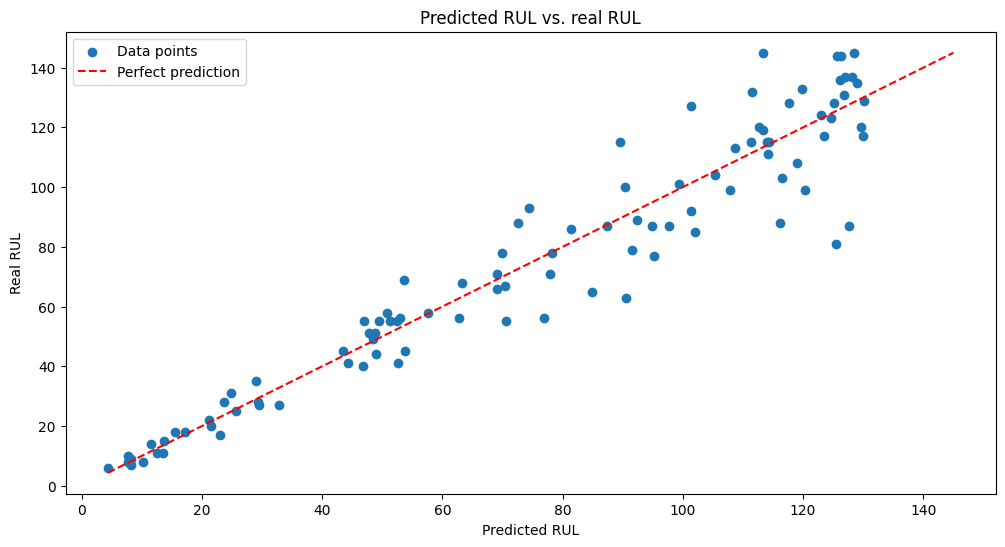

In [121]:
plot_results(X_test_scaled, turbine3_rul_test, model)

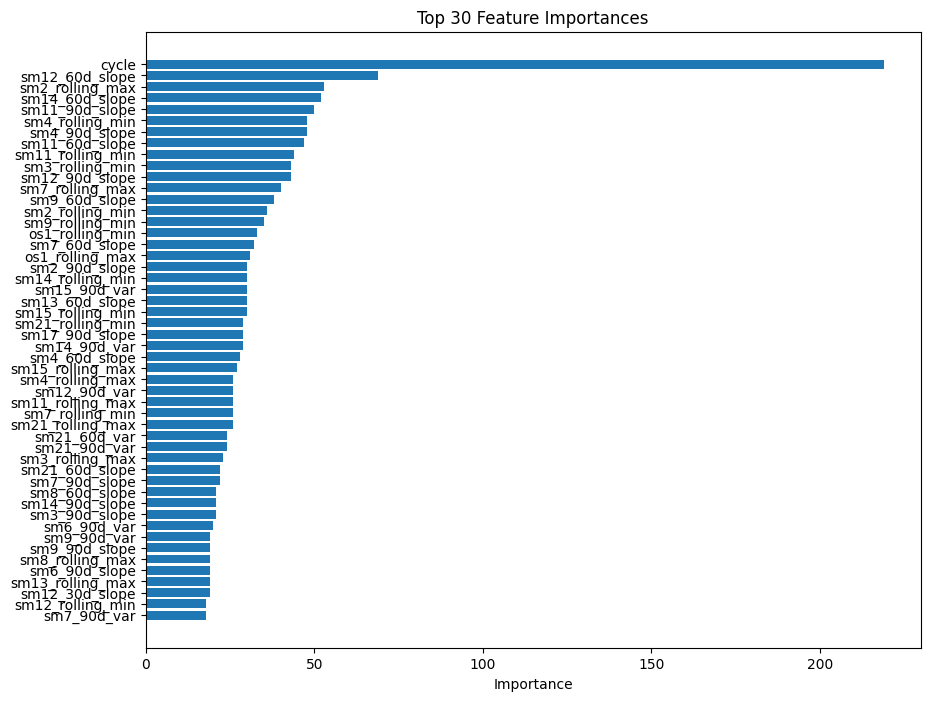

In [122]:
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Sort and select the top 30 most important features
top_50_features = feature_importance_df.head(50)

# Create a horizontal bar chart of the top 30 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

## Turbine 4

Bad resulst, further analysis needed. Propably due to different operational modes and overfitting. Same as for turbine 2 we need a different boarder for capping.

In [123]:
turbine4_train = remove_low_variation_columns(turbine4_train)
turbine4_test = remove_low_variation_columns(turbine4_test)

Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21', 'RUL']
Remaining columns: ['unitnr', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']


In [124]:
columns_train = turbine4_train.filter(regex='sm|os').columns.tolist()

# Print the list of column names
print(columns_train)

['os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5', 'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14', 'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21']


In [125]:
# Initialize the scaler
scaler = StandardScaler()

# Prepare training data
X_train = turbine4_train.drop(columns=["RUL", "unitnr"])  # Assuming 'RUL' and 'unitnr' need to be dropped
X_train_scaled = scaler.fit_transform(X_train)
Y_train = turbine4_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 130))

# Train the model
model = train(X_train_scaled, Y_train)

# Prepare and scale test data
X_test_scaled = get_last_and_scale(turbine4_test, scaler)

# Test the model
test(X_test_scaled, turbine4_rul_test, model)

Der RMSE auf Trainingsdaten ist : 16.22681153806922
Der Custom Score auf den Trainingsdaten ist:  8.835178460908747
Der RMSE auf Testdaten ist : 28.157555233412197
Der Custom Score auf den Testdaten ist:  22.583966299040863



In [126]:
# Enhance features for the training data
X_train_enhanced = enhance_turbofan_features(turbine4_train, columns_train)  # Assuming 'columns_train' is defined
X_train = X_train_enhanced.drop(columns=["unitnr", "RUL"])
X_train_scaled = scaler.fit_transform(X_train)
Y_train = turbine4_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 130))

# Enhance features for the test data
X_test_enhanced = enhance_turbofan_features(turbine4_test, columns_train)
X_test_scaled = get_last_and_scale(X_test_enhanced, scaler)  # Use the same scaler as before

# Train the model with enhanced features
model = train(X_train_scaled, Y_train)

# Test the model with enhanced features
test(X_test_scaled, turbine4_rul_test, model)

Der RMSE auf Trainingsdaten ist : 5.394199068750754
Der Custom Score auf den Trainingsdaten ist:  0.5164067920451403
Der RMSE auf Testdaten ist : 28.505628246728172
Der Custom Score auf den Testdaten ist:  37.3675872377033



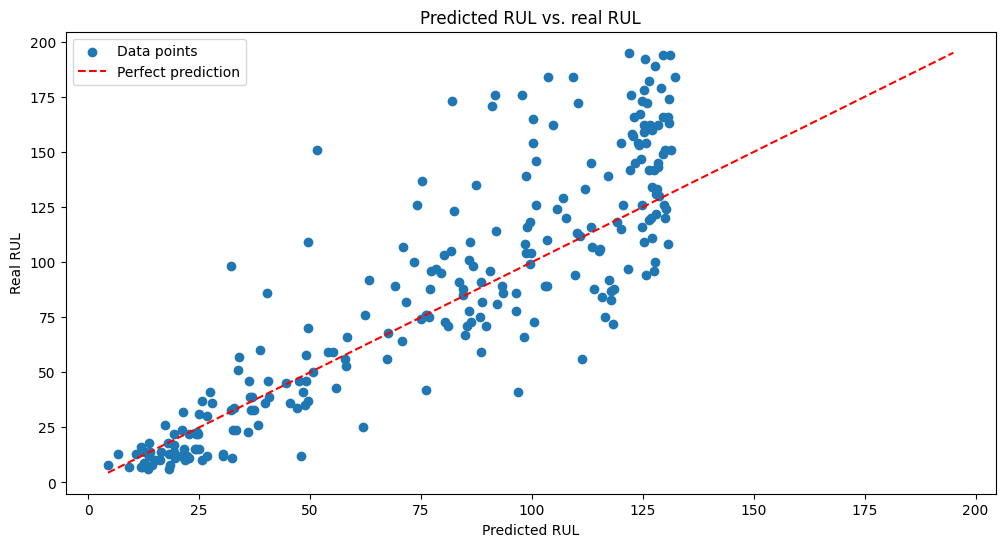

In [127]:
plot_results(X_test_scaled, turbine4_rul_test, model)

In [128]:
#try with another cap, slightly better

Y_train = turbine4_train["RUL"]
Y_train = Y_train.apply(lambda x: min(x, 170))

# Train the model with enhanced features
model = train(X_train_scaled, Y_train)

# Test the model with enhanced features
test(X_test_scaled, turbine4_rul_test, model)

Der RMSE auf Trainingsdaten ist : 7.537669415206112
Der Custom Score auf den Trainingsdaten ist:  0.9120871617784686
Der RMSE auf Testdaten ist : 28.27016601686731
Der Custom Score auf den Testdaten ist:  60.60375103904182



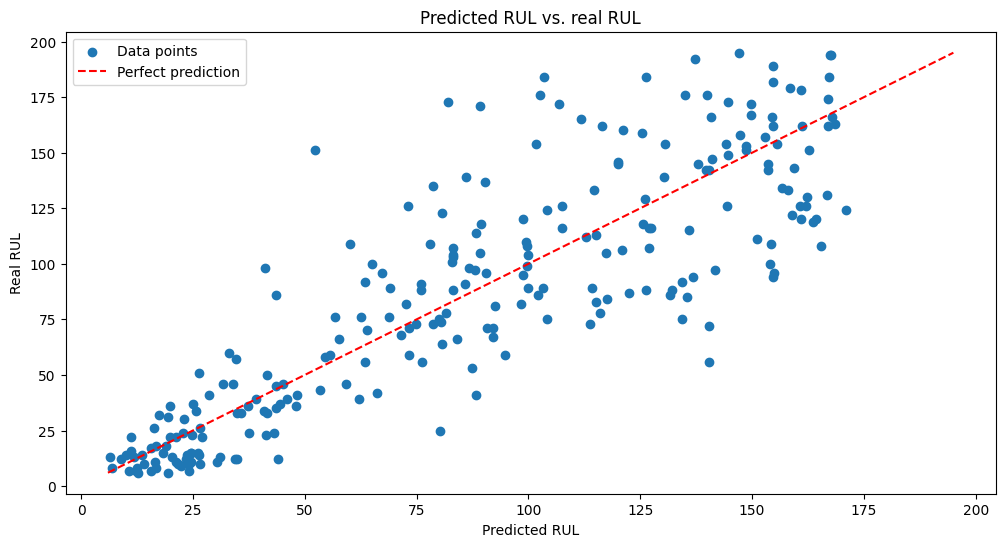

In [129]:
plot_results(X_test_scaled, turbine4_rul_test, model)

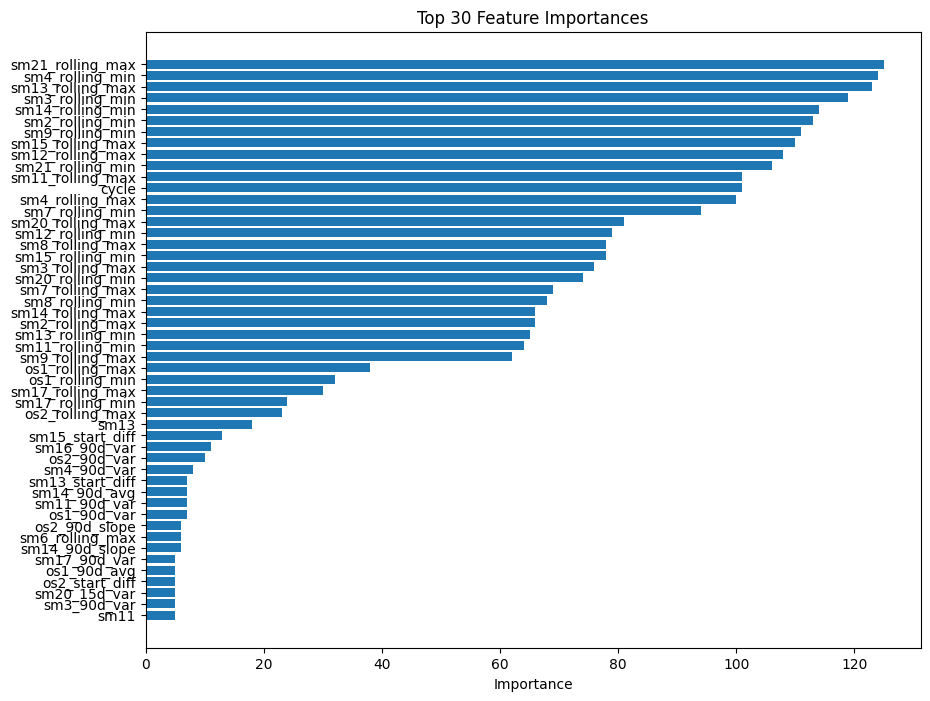

In [130]:
importances = model.feature_importances_
feature_names = X_train.columns

# Creating a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Sort and select the top 30 most important features
top_50_features = feature_importance_df.head(50)

# Create a horizontal bar chart of the top 30 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_50_features['Feature'], top_50_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

### Try to avoid overfitting

Here we could tune hyperparameter to generalize better on the traindata and to avoid overfitting

In [131]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

top_50_features = top_50_features['Feature'].tolist()

# Subset the scaled training and test DataFrames to include only the top 50 features
X_scaled_top50 = X_scaled_df[top_50_features]
X_test_scaled_top50 = X_test_scaled_df[top_50_features]

In [133]:
# Train the model
model = train(X_scaled_top50, Y_train, feature_fraction = 0.5, subsample = 0.5, reg_lambda = 5, reg_alpha = 5)

# Test the model
test(X_test_scaled_top50, turbine4_rul_test, model)

Der RMSE auf Trainingsdaten ist : 7.635193815770187
Der Custom Score auf den Trainingsdaten ist:  0.9349174366171675
Der RMSE auf Testdaten ist : 27.523957673308118
Der Custom Score auf den Testdaten ist:  40.564811305426055



# Summary and Future Steps

In this notebook and experiment we tested the importance of feature engineering for the NASA Turbofan Datasets. We could score really good resulsts on datasets 1 and 3, where only one operational setting exists, cut couldn't score good results for datsets 2 and 4 with several operational settings. For 2 and 4 we also score good results on the train data, but not on the test data. Here further research regarding the operational settings is needed.

For dataset 1 and 3 We could show that feature engineering is crucial and can improve the prediction results enormous, even without hyperparameter tuning of the learning models and without using high-end-models. Especially longterm trends like 60 and 90 day slope and variance seem to be important for the prediction of the remaining useful lifetime. Furthermore Extreme-Values (min and max) also seem to play an imporant role in the prediction.

With more time or in future reserearch, we would test further classical ML-approaches and would focus on Hyper-Parameter-Tuning for sets 1 and 3.
For Set 2 and 4 the feature engineering wasn't effective. We could create even more feautres with special focus on the operational settings, or use more advanced Models, like Neurol networks. Furthermore we should pay more attention on not overfitting for these two models